In [235]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

df = pd.read_csv('/Users/GS7271/Documents/MSDS7331/Project/train_set.csv')

del df['tube_assembly']
del df['tube_assembly.1']
del df['spec10']

df['quote_date'] = pd.to_datetime(df['quote_date'],format="%Y-%m-%d")

df = df.replace("Y", 1)
df = df.replace("N", 0)
df = df.replace("Yes", 1)
df = df.replace("No", 0)

df['bracket_pricing']=df['bracket_pricing'].astype('bool')
df['end_a_1x']=df['end_a_1x'].astype('bool')
df['end_a_2x']=df['end_a_2x'].astype('bool')
df['end_x_1x']=df['end_x_1x'].astype('bool')
df['end_x_2x']=df['end_x_2x'].astype('bool')

continuous_features = ['cost', 'diameter', 'wall', 'length', 'bend_radius']
categ_features = ['tube_assembly_id', 'supplier', 'spec1', 'spec2', 'spec3', 'spec4', 'spec5', 'spec6', 'spec7', 'spec8', 'spec9', 'material_id','end_a', 'end_x']
boolean_features = ['bracket_pricing','end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x']
integer_features = ['annual_usage', 'quantity', 'min_order_quantity', 'num_bends', 'num_boss', 'num_bracket', 'other']

df[integer_features] = df[integer_features].astype(np.int64)

print(df.info())
df.dtypes
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30213 entries, 0 to 30212
Data columns (total 32 columns):
tube_assembly_id      30213 non-null object
supplier              30213 non-null object
quote_date            30213 non-null datetime64[ns]
annual_usage          30213 non-null int64
min_order_quantity    30213 non-null int64
bracket_pricing       30213 non-null bool
quantity              30213 non-null int64
cost                  30213 non-null float64
spec1                 5797 non-null object
spec2                 5551 non-null object
spec3                 4650 non-null object
spec4                 3336 non-null object
spec5                 2312 non-null object
spec6                 1687 non-null object
spec7                 306 non-null object
spec8                 56 non-null object
spec9                 4 non-null object
material_id           29984 non-null object
diameter              30213 non-null float64
wall                  30213 non-null float64
length              

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,spec1,spec2,...,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
30208,TA-21190,S-0041,2013-09-10,869,75,False,75,5.945260,NaN,NaN,...,31.75,False,False,False,False,EF-003,EF-018,0,0,0
30209,TA-21191,S-0041,2013-09-10,752,1,False,1,6.131658,SP-0007,SP-0024,...,31.75,False,False,False,False,EF-003,EF-018,0,0,0
30210,TA-21195,S-0041,2013-08-05,1,80,False,80,5.066130,NaN,NaN,...,38.10,False,False,False,False,EF-003,EF-009,0,0,0
30211,TA-21196,S-0062,2005-05-09,422,1,False,1,18.214141,SP-0007,SP-0080,...,50.80,True,True,False,False,EF-003,EF-017,0,0,0
30212,TA-21197,S-0026,2009-07-30,3,1,False,1,53.618624,SP-0007,SP-0080,...,50.80,True,True,False,False,EF-003,EF-017,0,0,0


In [236]:
df.describe()

,annual_usage,min_order_quantity,quantity,cost,diameter,wall,length,num_bends,bend_radius,num_boss,num_bracket,other
count,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000
mean,120.369377,2.084699,38.389369,13.433317,17.223018,1.384782,97.647605,3.813061,42.231223,0.025254,0.003542,0.013603
std,1590.331872,12.742776,70.761392,28.663200,18.125973,0.638610,63.230131,2.199564,200.313458,0.184975,0.069664,0.150840
min,0.000000,0.000000,1.000000,0.503553,3.180000,0.710000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,3.878190,9.520000,0.890000,48.000000,2.000000,19.050000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,10.000000,6.521146,12.700000,1.240000,86.000000,3.000000,31.750000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,40.000000,13.431781,19.050000,1.650000,133.000000,5.000000,50.800000,0.000000,0.000000,0.000000
max,150000.000000,535.000000,2500.000000,1000.000000,203.200000,7.900000,1333.000000,17.000000,9999.000000,5.000000,3.000000,8.000000


Enter Tube Assembly ID: TA-00108


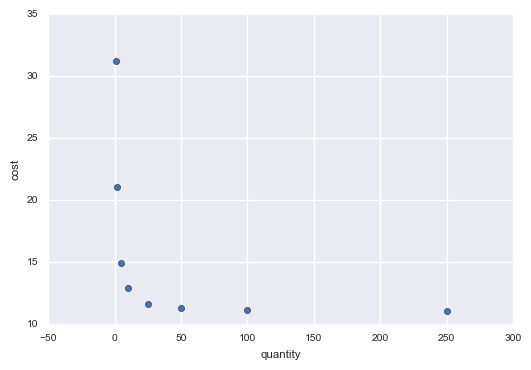

In [237]:
input_tube_assembly = raw_input('Enter Tube Assembly ID: ')

df[df.tube_assembly_id == input_tube_assembly].plot.scatter(x = 'quantity', y = 'cost')

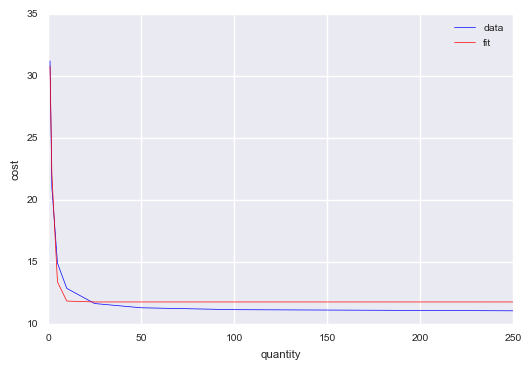

In [238]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

xdata = df[df.tube_assembly_id == input_tube_assembly].quantity
ydata = df[df.tube_assembly_id == input_tube_assembly].cost
popt, pcov = curve_fit(func, xdata, ydata)
plt.plot(xdata, ydata, 'b-', label='data')
plt.plot(xdata, func(xdata, *popt), 'r-', label='fit')
plt.xlabel('quantity')
plt.ylabel('cost')
plt.legend()
plt.show()

In [239]:
df_grouped = df.groupby(by = ['tube_assembly_id','supplier', 'material_id'])
df_grouped

In [240]:
fixed_cost = df.groupby(by = 'tube_assembly_id').max().cost - df.groupby(by = 'tube_assembly_id').min().cost
variable_cost = df.groupby(by = 'tube_assembly_id').min().cost

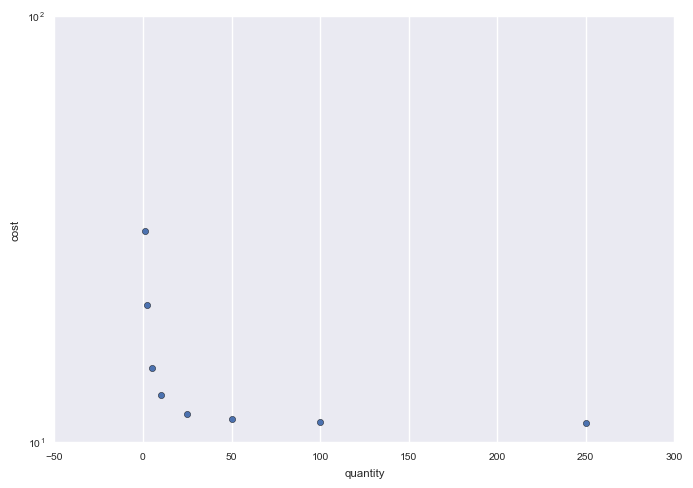

In [259]:
ax = df[df.tube_assembly_id == input_tube_assembly].plot.scatter(x = 'quantity', y = 'cost')
ax.set_yscale('log')

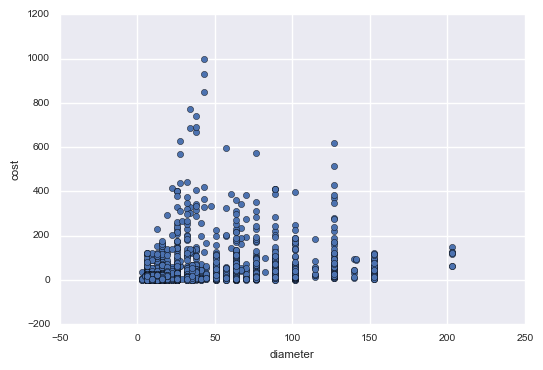

In [242]:
df[df.quantity == 1].plot.scatter(x = 'diameter', y = 'cost')

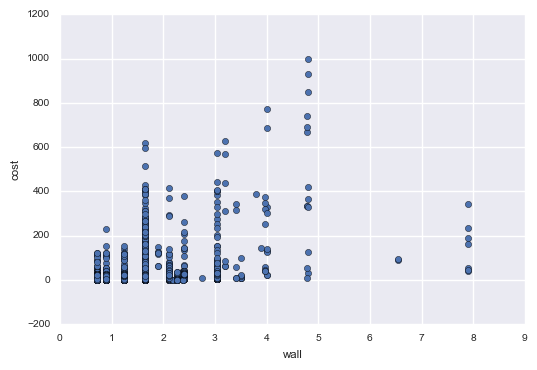

In [243]:
df[df.quantity == 1].plot.scatter(x = 'wall', y = 'cost')

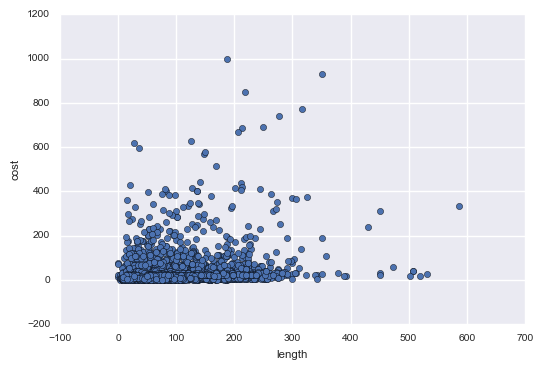

In [244]:
df[df.quantity == 1].plot.scatter(x = 'length', y = 'cost')

(0, 210)

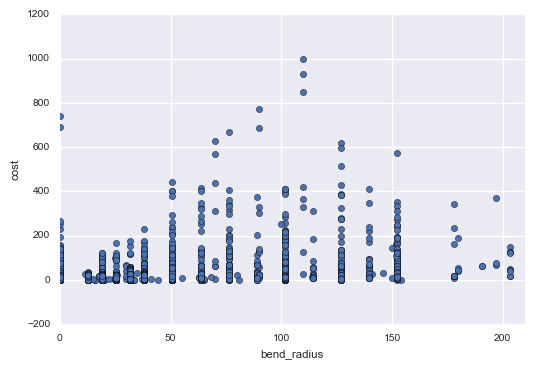

In [245]:
ax = df[df.quantity == 1].plot.scatter(x = 'bend_radius', y = 'cost')
ax.set_xlim(0, 210)

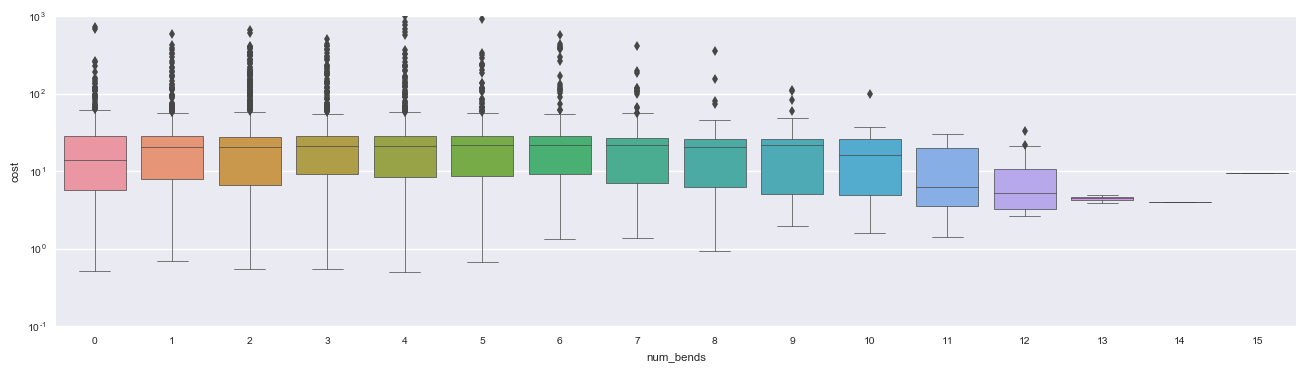

In [252]:
plt.figure(figsize = (16, 4))
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=0.75, rc={"lines.linewidth": 0.5})
ax = sns.boxplot(x = "num_bends", y = "cost", data = df[df.quantity == 1])
sns.despine(left = True)
ax.set_yscale('log')

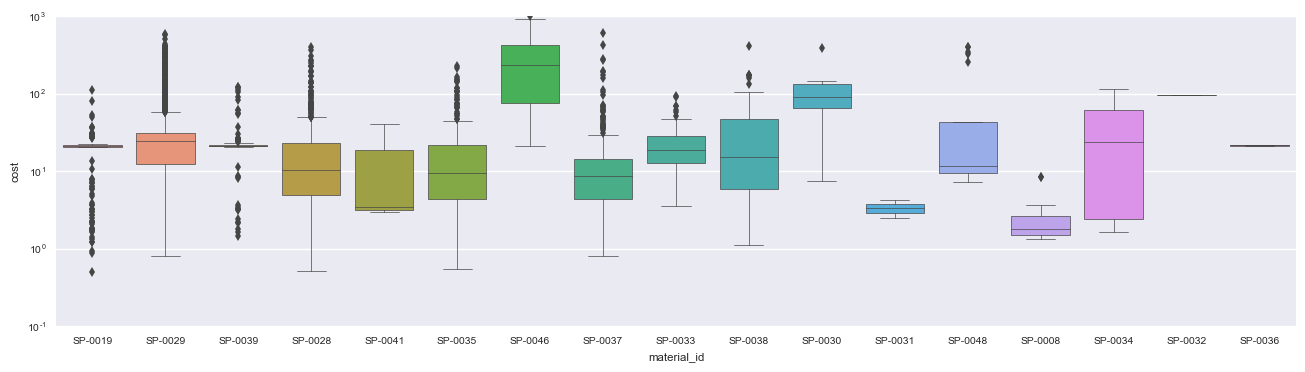

In [246]:
plt.figure(figsize = (16, 4))
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=0.75, rc={"lines.linewidth": 0.5})
ax = sns.boxplot(x = "material_id", y = "cost", data = df[df.quantity == 1])
sns.despine(left = True)
ax.set_yscale('log')

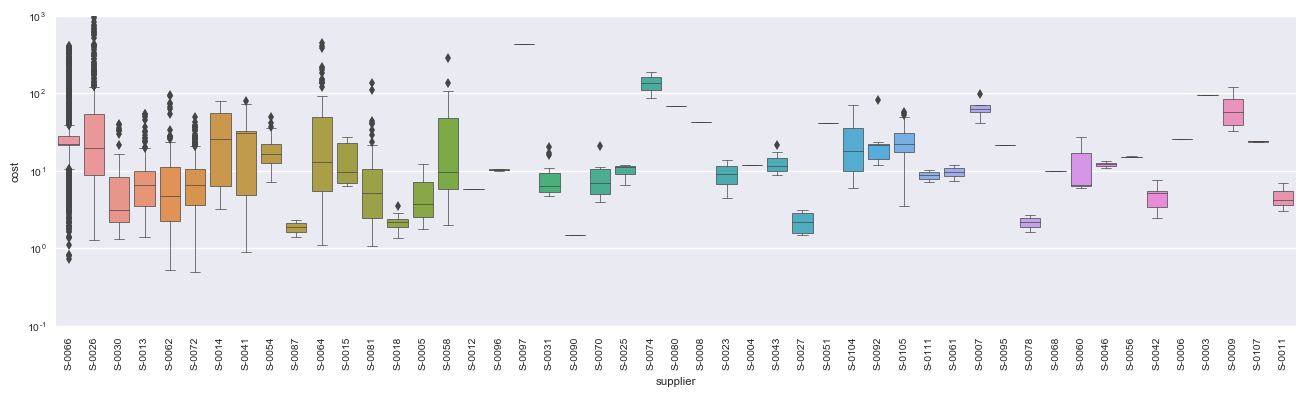

In [247]:
plt.figure(figsize = (16, 4))
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=0.75, rc={"lines.linewidth": 0.5})
ax = sns.boxplot(x = "supplier", y = "cost", data = df[df.quantity == 1])
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
sns.despine(left = True)
ax.set_yscale('log')

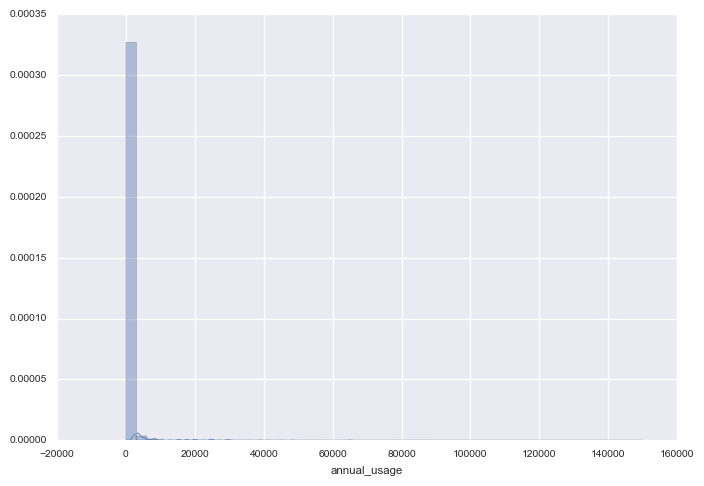

In [248]:
sns.distplot(df[df.quantity == 1].annual_usage)

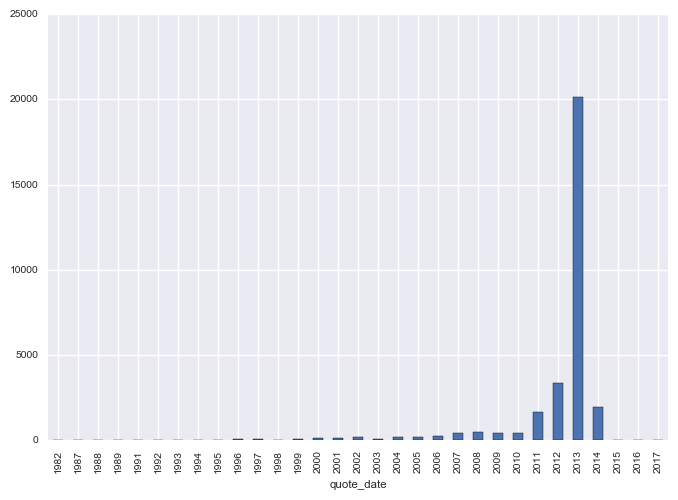

In [249]:
df.groupby(df["quote_date"].dt.year)["quote_date"].count().plot(kind="bar")

In [233]:
print(df.groupby(df["quote_date"].dt.year)["quote_date"].count())

quote_date
1982        6
1987        1
1988        2
1989        2
1991        2
1992        3
1993        4
1994        9
1995       28
1996       47
1997       63
1998       29
1999       79
2000      156
2001      146
2002      187
2003       91
2004      170
2005      180
2006      229
2007      400
2008      478
2009      410
2010      419
2011     1641
2012     3358
2013    20118
2014     1929
2015       22
2016        3
2017        1
Name: quote_date, dtype: int64


Enter Material ID: SP-0019
Enter Wall Thickness: 0.71


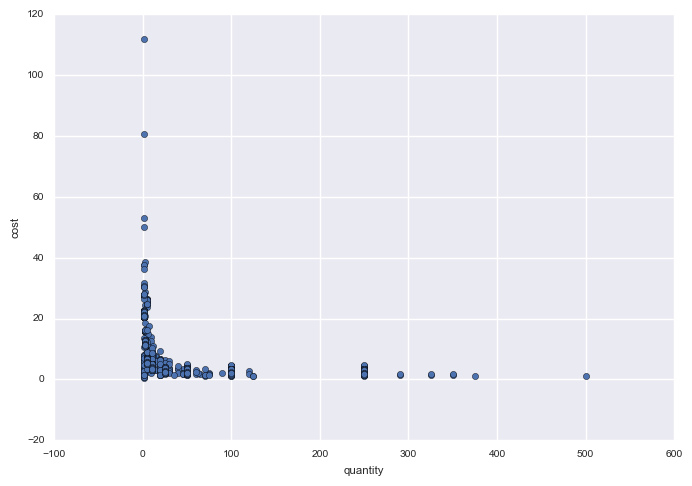

In [264]:
input_material = raw_input('Enter Material ID: ')
input_wall = raw_input('Enter Wall Thickness: ')
df[df.material_id == input_material].plot.scatter(x = 'quantity', y = 'cost')


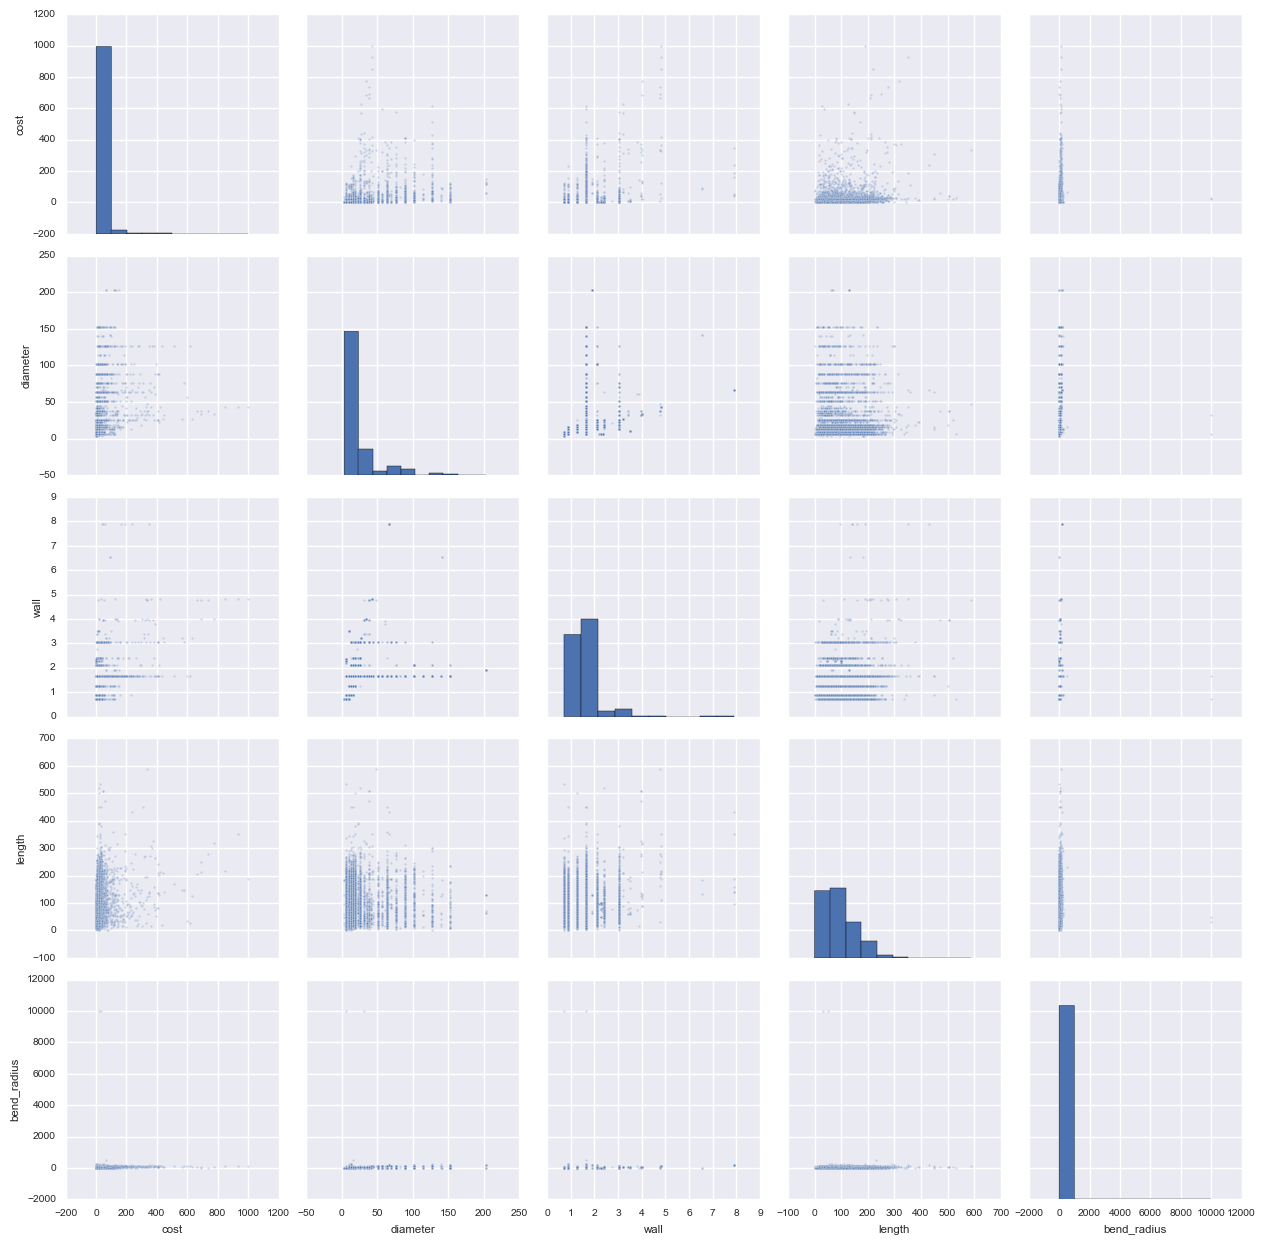

In [267]:
g = sns.pairplot(df[df.quantity == 1][continuous_features], plot_kws = {'s': 3, 'alpha': 0.25})

In [175]:
pd.get_dummies(df['bracket_pricing'], prefix = "bracket", drop_first = True)

,bracket_True
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0
